# Project Question

> Create a search function to search in a NAS space for the best performing **CNN architecture** on fashion-mnist.

Your task is to create a search function which searches for the model genome string that provides the best accuracy while using the least number of parameters.

Your program will return a model genome string (described below) which can be fed to a train function (provided below) to get the lowest parameter count and best accuracy after training.

**This is an open research problem**. You can use any method to search for the best genome and there might not be a perfect solution possible (prefect in the sense of maximum accuracy with minimum parameters). You will likely find tradeoffs between accuracy and number of parameters and you must balance such tradeoffs at your discretion.

> Aim for a search function that finds a genome with accuracy at least 75%.

You are encouraged to experiment with different techniques and apply your intuition to find a good search algorithm.

## CNN Architecture Constraints

Your search algorithm should search for models with the following basic structure.

Sequential model (no skip connections) having the following layers,
- Any number of normal(NC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A normal CNN layer has the following constraints,
    - `stride=1`
    - `padding=same`
    - `1 <= kernel size < 8`
    - Any of the following activation functions,
      - relu
      - sigmoid
      - tanh
      - swish
      - gelu
- **Exactly** 2 reduction(RC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A reduction layer has the **same** constraints as the normal layer except the following,
    - `stride=2`
    - `padding=valid`
- **Exactly** the following structure as the **final layers**,
  - First, a Global Average Pooling 2D layer.
    - `torch.nn.AvgPool2d(kernel_size=layer_input_image_size)` or `tf.keras.layers.GlobalAveragePooling2D`
  - Then, a Fully Connected/Dense layer with 64 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(64)` or `tf.keras.layers.Dense(64)`
  - Then, a Fully Connected/Dense layer with 10 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(10)` or `tf.keras.layers.Dense(10)`


The normal(NC) and reduction(RC) layers can be in **any order** as long as the constraints above are maintained.

The final layers of you model should be exactly as mentioned in these constraints.

All of the above contraints **apply only to your final output**. During searching for the best architecture you can do whatever you want.

Once your algorithm finds the best architecture, it should represent the architecture as a genome string (explained below) which will be fed to the training function given below to get the final accuracy.

In [1]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 34.3 MB/s 


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


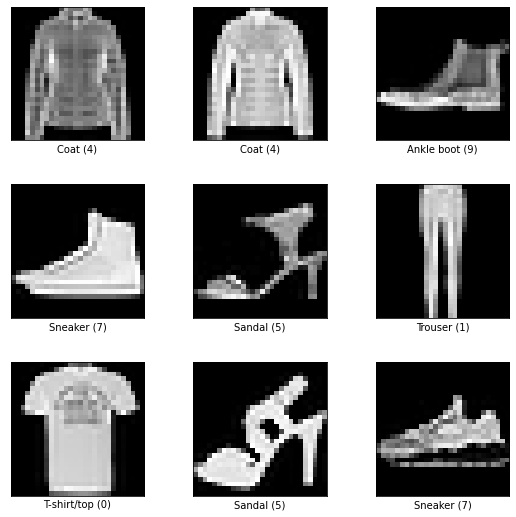

In [2]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [3]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [4]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "RC 10 3 tanh;NC 20 3 relu;RC 10 3 swish;FL swish;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 10)        100       
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 20)        1820      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 10)          1810      
                                                                 
 global_average_pooling2d (G  (None, 10)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

In [5]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None,epo: int=1):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=epo,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

In [7]:
#@title Use this form to train specific genomes
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "RC 43 1 swish;RC 122 6 sigmoid;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: RC 43 1 swish;RC 122 6 sigmoid;FL relu;
Model params: 197586
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 14, 14, 43)        86        
                                                                 
 Layer_1_RC (Conv2D)         (None, 5, 5, 122)         188978    
                                                                 
 global_average_pooling2d_2   (None, 122)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                7872      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 197,586
Trainable params: 19

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.5116000175476074
Return value: (0.5116000175476074, 0.3525499999523163, 197586)


In [ ]:
#@title Deep model genome example
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;
Model params: 607946
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 64)        128       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 64)        4160      
                                                                 
 Layer_3_RC (Conv2D)         (None, 13, 13, 128)       73856     
                                                                 
 Layer_4_NC (Conv2D)         (None, 13, 13, 128)       16512     
                                                                 
 Layer_5_NC (Conv2D)         (

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8097000122070312
Return value: (0.8097000122070312, 0.6823999881744385, 607946)


## Hints

- Consider caching genome results for faster querying.
  - This has a risk. The training process itself is non-deterministic and thus training the same genome multiple times can sometimes give drastically different results. Generally such difference in accuracy of the same genome is small but sometimes it be upto 30%.
- Consider saving your search algorithm state such that it can resume from a previous search point if it gets interrupted due to a crash or colab time restrictions.
  - Google colab is free and hence it has time limits on how long you can use the GPU. If you implement checkpointing in your code such that it saves checkpoints on your GDrive, you can save a lot of time when such interruptions happen.
  - You can mount your GDrive to colab and save/load files from your drive folders.
- Don't forget to enable GPU in colab.
  - https://colab.research.google.com/notebooks/gpu.ipynb
- If colab shows errors in code that was working before try to do `Runtime->Restart Runtime`. This is especially true if you stopped execution while a model was being trained.
  - You can also try `Runtime->Factory Reset Runtime` to get a clean slate (revert installed libraries to colab defaults).

# Answer
Write your answer and its code under this section.

In [ ]:
import math
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### NSGA II Algorithm Implementation

In [ ]:
# credits: https://medium.com/@rossleecooloh/optimization-algorithm-nsga-ii-and-python-package-deap-fca0be6b2ffc
from collections import defaultdict


def dominates(obj1, obj2, sign=[1, 1]):

    indicator = False
    for a, b, sign in zip(obj1, obj2, sign):
        if a * sign > b * sign:
            indicator = True
        # if one of the objectives is dominated, then return False
        elif a * sign < b * sign:
            return False
    return indicator


def sortNondominated(fitness, k=None, first_front_only=False):
    if k is None:
        k = len(fitness)

    # Use objectives as keys to make python dictionary
    map_fit_ind = defaultdict(list)
    for i, f_value in enumerate(fitness):  # fitness = [(1, 2), (2, 2), (3, 1), (1, 4), (1, 1)...]
        map_fit_ind[f_value].append(i)
    fits = list(map_fit_ind.keys())  # fitness values

    current_front = []
    next_front = []
    dominating_fits = defaultdict(int)  # n (The number of people dominate you)
    dominated_fits = defaultdict(list)  # Sp (The people you dominate)

    # Rank first Pareto front
    # *fits* is a iterable list of chromosomes. Each has multiple objectives.
    for i, fit_i in enumerate(fits):
        for fit_j in fits[i + 1:]:
            # Eventhougn equals or empty list, n & Sp won't be affected
            if dominates(fit_i, fit_j):
                dominating_fits[fit_j] += 1  
                dominated_fits[fit_i].append(fit_j)  
            elif dominates(fit_j, fit_i):  
                dominating_fits[fit_i] += 1
                dominated_fits[fit_j].append(fit_i)
        if dominating_fits[fit_i] == 0: 
            current_front.append(fit_i)

    fronts = [[]]  # The first front
    for fit in current_front:
        fronts[-1].extend(map_fit_ind[fit])
    pareto_sorted = len(fronts[-1])

    # Rank the next front until all individuals are sorted or
    # the given number of individual are sorted.
    # If Sn=0 then the set of objectives belongs to the next front
    if not first_front_only:  # first front only
        N = min(len(fitness), k)
        while pareto_sorted < N:
            fronts.append([])
            for fit_p in current_front:
                # Iterate Sn in current fronts
                for fit_d in dominated_fits[fit_p]: 
                    dominating_fits[fit_d] -= 1  # Next front -> Sn - 1
                    if dominating_fits[fit_d] == 0:  # Sn=0 -> next front
                        next_front.append(fit_d)
                         # Count and append chromosomes with same objectives
                        pareto_sorted += len(map_fit_ind[fit_d]) 
                        fronts[-1].extend(map_fit_ind[fit_d])
            current_front = next_front
            next_front = []

    return fronts

def CrowdingDist(fitness=None):

    # initialize list: [0.0, 0.0, 0.0, ...]
    distances = [0.0] * len(fitness)
    crowd = [(f_value, i) for i, f_value in enumerate(fitness)]  # create keys for fitness values

    n_obj = len(fitness[0])

    for i in range(n_obj):  # calculate for each objective
        crowd.sort(key=lambda element: element[0][i])
        # After sorting,  boundary solutions are assigned Inf 
        # crowd: [([obj_1, obj_2, ...], i_0), ([obj_1, obj_2, ...], i_1), ...]
        distances[crowd[0][1]] = float("Inf")
        distances[crowd[-1][1]] = float("inf")
        if crowd[-1][0][i] == crowd[0][0][i]:  # If objective values are same, skip this loop
            continue
        # normalization (max - min) as Denominator
        norm = float(crowd[-1][0][i] - crowd[0][0][i])
        # crowd: [([obj_1, obj_2, ...], i_0), ([obj_1, obj_2, ...], i_1), ...]
        # calculate each individual's Crowding Distance of i th objective
        # technique: shift the list and zip
        for prev, cur, next in zip(crowd[:-2], crowd[1:-1], crowd[2:]):
            distances[cur[1]] += (next[0][i] - prev[0][i]) / norm  # sum up the distance of ith individual along each of the objectives

    return distances

### Naive Objective Combining Function

In [ ]:
# Our own intuition based objective function
def cost(acc_and_param):
  acc=0.8*acc_and_param[0]+0.2*acc_and_param[1]
  w_acc=(1-8/15*acc)
  w_param=1-w_acc
  cost_v=w_acc*acc + w_param*(10000.0/acc_and_param[2])
  return cost_v

In [ ]:
# list form to genome string
def convert_gnome(model_list):
  genome_str = ''
  act_dict = {0:'relu', 1:'sigmoid', 2:'tanh', 3:'swish', 4:'gelu'}
  for l in model_list[:-1]:
    if len(l) == 4 and l[0] == 1:
      genome_str += 'NC '+ str(l[1]) + ' ' + str(l[2]) + ' ' + act_dict[l[-1]] + ';'
    else:
      genome_str += 'RC '+ str(l[1]) + ' ' + str(l[2]) + ' ' + act_dict[l[-1]] + ';'
  genome_str += 'FL ' + act_dict[model_list[-1][-1]] + ';'
  return genome_str

In [ ]:
# Selection based on single objective
def select_best_candidate(selection_percentage,current_population,acc_and_param):
  size=math.floor(selection_percentage*len(current_population))
  list2=[]
  for x in range(len(current_population)):
    listn=[]
    listn.append(current_population[x])
    listn.append(x)
    listn.append(cost(acc_and_param[x]))
    list2.append(listn)
  list4=sorted(list2,key=lambda x:x[2],reverse=True)[:size]
  new_list=[item[0] for item in list2 if item not in list4]
  best_cand=[item[0] for item in list4]
  current_population=list(new_list)
  return best_cand,new_list

In [ ]:
# selection based on NSGA2
def NSGA2(selection_percentage, current_population, acc_and_param):
  size = math.floor(selection_percentage*len(current_population))
  fronts = sortNondominated(acc_and_param)
  sz = 0
  best_cand_ids = []
  for front in fronts:
    sz += len(front)
    if sz < size:
      best_cand_ids += front
    elif sz == size:
      best_cand_ids += front
      break
    else:
      crow_num = len(front) - (sz - size)
      front_objs = [acc_and_param[i] for i in front]
      crow_dists = CrowdingDist(front_objs)
      crow_with_ids = sorted(zip(crow_dists, front), reverse = True)
      _, crow_ids = zip(*crow_with_ids)
      best_cand_ids += crow_ids[:crow_num]
      break
  best_cand = []
  new_list = [] # non-best
  for id, candi in enumerate(current_population):
    if id in best_cand_ids:
      best_cand.append(candi)
    else:
      new_list.append(candi)
  return best_cand, new_list

In [ ]:
# Population Sampling
def select_randomly(current_population,size):
  random_cand=random.sample(current_population,size)
  return random_cand

In [ ]:
# Mating
def mate_candidate(new_population,recombination_rate):
  size=len(new_population)
  # 
  # size=math.floor(size)
  x=math.floor(random.randint(2,size)*recombination_rate)
  size=math.floor(size/2)
  
  child=[]
  # for 
  for i in range(x):
    z=random.randint(0,size)
    k=random.randint(size+1,len(new_population)-1)
    sizeone=len(new_population[z])
    sizetwo=len(new_population[k])
    # l=random.randint(0,sizeone-1)
    # m=random.randint(0,sizetwo-1)
    mi=min(sizeone,sizetwo)
    x=l=random.randint(0,mi)
    l=random.sample(range(0,sizeone),x)
    m=random.sample(range(0,sizetwo),x)
    ch1=list(new_population[z])
    ch2=list(new_population[k])
    for c in range(x):
      if ch1[l[c]][0]==ch2[m[c]][0]:
        temp=ch1[l[c]]
        ch1[l[c]]=ch2[m[c]]
        ch2[m[c]]=temp
    child.append(ch1)
    child.append(ch2)
  

  return child


In [ ]:
# Mutate Chromosome
def mutate_candidate(new_population,mutation_rate):
  num = int(mutation_rate*len(new_population))
  to_mutate = random.sample(new_population, num)
  mutated = []
  for cand in to_mutate:
    chos = random.randint(0, len(cand)- 2)
    pos = random.randint(1,3)
    if pos == 1:
      new = random.randint(32, 256)
      cand[chos][pos] = new
      mutated.append(cand)
    elif pos == 2:
      new = random.randint(1,7)
      if new%2 == 0: new += 1
      cand[chos][pos] = new
      mutated.append(cand)
    elif pos == 3:
      new = random.randint(0,4)
      cand[chos][pos] = new
      mutated.append(cand)
  return mutated

In [ ]:
# final selection for best model
def find_best_performing_gnome(current_population,acc_and_param):
  max=0
  for i in range(len(acc_and_param)):
    if cost(acc_and_param[i])>cost(acc_and_param[max]):
      max=i
  return current_population[max]

In [ ]:
# Final selection using NSGA II (set of architectures (first pareto front))
def best_performing(current_population, acc_and_param,full_acc):
  fronts = sortNondominated(acc_and_param)
  best = [current_population[i] for i in fronts[0]]
  acc=[full_acc[i] for i in fronts[0]]
  return best,acc


In [ ]:
# initialize_population
import random

def initialize_population(population_size):
  # rand=[[0,8,3,0],[0,6,4,1],[2,1]]
  population=[]
  # population.append(rand)
  for i in range(population_size):
    x=random.randint(0,4)
    gn_string=[]
    for j in range(x):
      layer=[]
      layer.append(1)
      y=random.randint(32,128)
      layer.append(y)
      y=random.randint(1,7)
      layer.append(y)
      y=random.randint(0,4)
      layer.append(y)
      gn_string.append(layer)
    rc_layer=[]
    rc_layer.append(0)
    z=random.randint(32,128)
    rc_layer.append(z)
    z=random.randint(1,7)
    rc_layer.append(z)
    z=random.randint(0,4)
    rc_layer.append(z)
    gn_string.append(rc_layer)
    x=random.randint(0,4)
    for j in range(x):
      layer=[]
      layer.append(1)
      y=random.randint(32,128)
      layer.append(y)
      y=random.randint(1,7)
      layer.append(y)
      y=random.randint(0,4)
      layer.append(y)
      gn_string.append(layer)
    rc_layer=[]
    rc_layer.append(0)
    z=random.randint(32,128)
    rc_layer.append(z)
    z=random.randint(1,7)
    rc_layer.append(z)
    z=random.randint(0,4)
    rc_layer.append(z)
    gn_string.append(rc_layer)
    z=random.randint(0,4)
    gn_string.append([2,z])
    population.append(gn_string)
  print(population)
  return population




In [ ]:
# Main (combining all above)
from copy import deepcopy
import pickle
def Evolutionary_algo(no_of_iterations=4,population_size=15,recombination_rate=0.3,mutation_rate=0.3,selection_percentage=0.4):
  current_population=initialize_population(population_size)
  for i in range(no_of_iterations):
    acc_and_param = []
    full_acc = []
    for i in range(len(current_population)):

      # convert into genome str
      gnome = convert_gnome(current_population[i])

      # send genome str into the train function   
      test_acc,train_acc,n_para = train_model(gnome, 1,  1e-3, 0.1,epo = 1)
      acc_and_param.append((0.8*test_acc + 0.2*train_acc, 1.0/n_para)) # append all the objective values

    best_candidates,current_population2 = NSGA2(selection_percentage,current_population,acc_and_param)

    current_population_size=len(current_population2)
    size=math.floor(current_population_size*(1-selection_percentage))
    random_candidates = select_randomly(current_population2, size)

    new_population=[]
    new_population += best_candidates 
    new_population += random_candidates

    child_candidate = mate_candidate(new_population,recombination_rate)

    mutated_canditate = mutate_candidate(new_population,mutation_rate)

    new_population += child_candidate
    new_population += mutated_canditate
    current_population = new_population
    # with open()-------------------------------------------
    save_copy = deepcopy(current_population)
    save_copy.append(i)
    with open('current_population.pickle', 'wb') as handle:
      pickle.dump(save_copy, handle, protocol=pickle.HIGHEST_PROTOCOL)
      handle.close()
    # ------------------------------------------------------

  acc_and_param=[]
  full_acc = []
  for i in range(population_size):
    gnome=convert_gnome(current_population[i])
    test_acc,train_acc,n_para=train_model(gnome, 1,  1e-3,  0.1,epo=2)
    acc_and_param.append((0.8*test_acc + 0.2*train_acc, 1.0/n_para))
    full_acc.append([test_acc,train_acc,n_para])
  best_can, acc = best_performing(current_population,acc_and_param,full_acc)
  #best_gnome=convert_gnome(best_can)
  #print(best_gnome)
  return best_can, acc


In [ ]:
import pickle
best_model,acc=Evolutionary_algo(5,6,0.6,0.6,0.4)
# print(best_model)

[[[1, 108, 3, 1], [0, 51, 4, 3], [1, 95, 6, 2], [1, 128, 6, 3], [0, 102, 7, 2], [2, 3]], [[1, 67, 4, 0], [0, 103, 3, 3], [1, 43, 6, 3], [1, 43, 1, 4], [1, 68, 4, 1], [1, 62, 3, 0], [0, 82, 6, 0], [2, 4]], [[1, 48, 4, 4], [1, 94, 7, 1], [1, 115, 1, 3], [0, 61, 3, 0], [1, 117, 5, 0], [1, 82, 2, 4], [1, 108, 7, 4], [0, 35, 1, 0], [2, 2]], [[1, 93, 5, 4], [1, 48, 6, 3], [1, 80, 6, 1], [0, 43, 7, 4], [1, 34, 5, 0], [1, 41, 5, 1], [0, 63, 1, 2], [2, 4]], [[1, 114, 3, 4], [1, 73, 7, 2], [0, 72, 3, 3], [1, 109, 6, 3], [1, 59, 6, 3], [1, 71, 1, 0], [1, 114, 7, 0], [0, 70, 4, 4], [2, 4]], [[1, 71, 4, 2], [0, 78, 4, 3], [1, 61, 1, 1], [1, 122, 5, 1], [1, 128, 5, 4], [1, 40, 6, 3], [0, 50, 4, 0], [2, 4]]]
Training genome: NC 108 3 sigmoid;RC 51 4 swish;NC 95 6 tanh;NC 128 6 swish;RC 102 7 tanh;FL swish;
Model params: 1348750


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 67 4 relu;RC 103 3 swish;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 498656


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7900000214576721
Training genome: NC 48 4 gelu;NC 94 7 sigmoid;NC 115 1 swish;RC 61 3 relu;NC 117 5 relu;NC 82 2 gelu;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 953940


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6434999704360962
Training genome: NC 93 5 gelu;NC 48 6 swish;NC 80 6 sigmoid;RC 43 7 gelu;NC 34 5 relu;NC 41 5 sigmoid;RC 63 1 tanh;FL gelu;
Model params: 548960


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7914000153541565
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 swish;NC 59 6 swish;NC 71 1 relu;NC 114 7 relu;RC 70 4 gelu;FL gelu;
Model params: 1504503


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8044000267982483
Training genome: NC 71 4 tanh;RC 78 4 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 gelu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 891736


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.26030001044273376
Training genome: NC 67 4 relu;RC 103 3 swish;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 498656


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7778000235557556
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 swish;NC 59 6 swish;NC 71 1 relu;NC 114 7 relu;RC 70 4 gelu;FL gelu;
Model params: 1504503


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8353000283241272
Training genome: NC 71 4 tanh;RC 78 4 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 891736


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.44940000772476196
Training genome: NC 48 4 gelu;NC 94 7 sigmoid;NC 115 1 swish;RC 226 3 relu;NC 117 5 relu;NC 82 2 gelu;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 1607505


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6201000213623047
Training genome: NC 82 2 gelu;RC 78 4 swish;NC 61 1 sigmoid;NC 115 1 swish;NC 48 4 gelu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 308265


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8003000020980835
Training genome: NC 128 5 relu;NC 94 7 sigmoid;NC 122 5 sigmoid;RC 226 3 relu;NC 117 5 relu;NC 71 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2304945


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 48 4 gelu;NC 94 7 sigmoid;NC 115 1 swish;RC 226 3 relu;NC 117 5 relu;NC 82 2 gelu;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 1607505


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7142000198364258
Training genome: NC 71 4 tanh;RC 78 4 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 891736


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7781000137329102
Training genome: NC 67 4 relu;RC 103 3 swish;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 498656


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.791700005531311
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 swish;NC 59 6 swish;NC 71 1 relu;NC 114 7 relu;RC 70 4 gelu;FL gelu;
Model params: 1504503


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7815999984741211
Training genome: NC 82 2 gelu;RC 228 5 swish;NC 61 1 sigmoid;NC 115 1 swish;NC 48 4 gelu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 682629


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7900000214576721
Training genome: NC 71 4 tanh;RC 228 5 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1217128


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7684000134468079
Training genome: NC 128 5 relu;NC 94 7 sigmoid;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 71 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2155631


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 71 4 tanh;RC 228 5 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1217128


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7605999708175659
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1509793


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 71 4 tanh;RC 228 5 swish;NC 61 1 sigmoid;NC 71 4 tanh;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 937123


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8034999966621399
Training genome: NC 128 5 relu;NC 94 7 sigmoid;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 71 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2155631


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.640500009059906
Training genome: NC 71 4 tanh;RC 228 5 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1217128


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8016999959945679
Training genome: NC 71 4 tanh;RC 228 5 swish;NC 61 1 sigmoid;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1217128


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7767000198364258
Training genome: NC 67 4 relu;RC 103 3 swish;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 498656


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8058000206947327
Training genome: NC 82 2 gelu;RC 228 5 swish;NC 61 1 relu;NC 115 1 swish;NC 48 4 gelu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 682629


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7684000134468079
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 1 relu;NC 141 4 tanh;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1629703


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8245999813079834
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 1 relu;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1617318


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7932999730110168
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 swish;NC 59 6 swish;NC 71 1 relu;NC 114 7 relu;RC 70 4 gelu;FL gelu;
Model params: 1504503


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8234999775886536
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 1 relu;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1617318


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8270999789237976
Training genome: NC 128 5 relu;NC 94 3 sigmoid;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 141 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2151261


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 1 relu;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1509793


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 swish;NC 59 6 swish;NC 71 1 relu;NC 114 7 relu;RC 50 4 relu;FL gelu;
Model params: 1466723


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8352000117301941
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 1 relu;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 70 4 gelu;FL gelu;
Model params: 1631418


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7973999977111816
Training genome: NC 141 4 tanh;RC 103 3 swish;NC 128 5 relu;NC 43 1 gelu;NC 61 1 relu;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 694334


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7989000082015991
Training genome: NC 67 4 relu;RC 228 5 swish;NC 68 4 sigmoid;NC 122 5 sigmoid;NC 43 6 swish;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1125744


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8044999837875366
Training genome: NC 94 3 sigmoid;RC 228 5 swish;NC 61 1 relu;NC 128 5 relu;NC 141 4 tanh;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1274218


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 115 1 swish;NC 82 2 gelu;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 48 4 gelu;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 1407374


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6162999868392944
Training genome: NC 128 5 relu;NC 94 3 sigmoid;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 141 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2151261


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 1 relu;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1617318


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6428999900817871
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 1 relu;NC 122 5 sigmoid;NC 128 5 relu;NC 40 6 swish;RC 50 4 relu;FL gelu;
Model params: 1509793


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 swish;NC 59 6 swish;NC 71 1 relu;NC 114 7 relu;RC 70 4 gelu;FL gelu;
Model params: 1504503


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8396000266075134
Training genome: NC 67 4 relu;RC 103 3 sigmoid;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 498656


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 82 2 gelu;RC 228 5 swish;NC 61 5 relu;NC 115 1 swish;NC 48 4 gelu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1016421


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7674000263214111
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 5 relu;NC 141 4 tanh;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1674727


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7688000202178955
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 sigmoid;NC 59 6 swish;NC 71 1 relu;NC 114 5 relu;RC 70 4 gelu;FL gelu;
Model params: 1310247


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8062999844551086
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 sigmoid;NC 59 6 swish;NC 71 1 relu;NC 114 5 relu;RC 50 4 relu;FL gelu;
Model params: 1272467


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8043000102043152
Training genome: NC 141 4 tanh;RC 103 3 sigmoid;NC 128 3 relu;NC 43 1 gelu;NC 61 5 relu;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 546342


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7827000021934509
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 sigmoid;NC 59 6 swish;NC 71 1 relu;NC 114 5 relu;RC 70 4 gelu;FL gelu;
Model params: 1310247


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8144000172615051
Training genome: NC 67 4 relu;RC 228 5 swish;NC 68 4 sigmoid;NC 122 5 sigmoid;NC 43 6 swish;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1125744


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 128 3 relu;NC 94 3 swish;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 141 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2149213


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6291999816894531
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 5 relu;NC 122 5 sigmoid;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1593729


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 5 relu;NC 122 5 sigmoid;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1701254


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.791100025177002
Training genome: NC 94 3 swish;RC 228 5 swish;NC 61 5 relu;NC 128 3 relu;NC 141 4 tanh;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1483082


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7687000036239624
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 5 relu;NC 122 5 sigmoid;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1701254


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.765999972820282
Training genome: NC 67 4 relu;RC 103 3 sigmoid;NC 40 6 sigmoid;NC 94 3 swish;NC 68 4 sigmoid;NC 61 5 relu;RC 82 6 relu;FL gelu;
Model params: 637862


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 43 1 gelu;RC 228 5 swish;NC 62 3 relu;NC 128 3 relu;NC 141 4 tanh;NC 43 6 swish;RC 50 4 relu;FL gelu;
Model params: 989836


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8241000175476074
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 50 4 relu;NC 61 5 relu;NC 128 3 relu;NC 94 3 swish;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 893898


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7671999931335449
Training genome: NC 71 1 relu;RC 228 5 swish;NC 109 6 sigmoid;NC 59 6 swish;NC 141 4 tanh;NC 114 5 relu;RC 72 3 swish;FL gelu;
Model params: 2145901


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.5799000263214111
Training genome: NC 67 4 relu;RC 103 3 sigmoid;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 498656


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7764999866485596
Training genome: NC 67 4 relu;RC 228 5 swish;NC 68 4 sigmoid;NC 122 5 sigmoid;NC 43 6 swish;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1125744


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 141 4 tanh;RC 228 5 swish;NC 61 5 relu;NC 141 4 tanh;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1674727


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.824400007724762
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 5 relu;NC 122 5 sigmoid;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1593729


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 128 3 relu;RC 103 3 sigmoid;NC 128 3 relu;NC 43 1 gelu;NC 61 5 relu;NC 122 5 sigmoid;RC 82 6 relu;FL gelu;
Model params: 862366


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 62 3 relu;RC 228 5 swish;NC 61 5 relu;NC 122 5 sigmoid;NC 141 4 tanh;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1402598


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.6715999841690063
Training genome: NC 122 5 sigmoid;NC 73 7 tanh;RC 72 3 swish;NC 109 6 sigmoid;NC 128 3 relu;NC 40 6 sigmoid;NC 114 5 relu;RC 70 4 gelu;FL gelu;
Model params: 1326766


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 5 relu;NC 114 3 gelu;NC 59 6 swish;NC 71 1 relu;RC 50 4 relu;FL gelu;
Model params: 1416480


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 94 3 swish;RC 228 5 swish;NC 61 5 relu;NC 128 3 relu;NC 141 4 tanh;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1483082


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.5062000155448914
Training genome: NC 122 5 sigmoid;RC 228 5 swish;NC 61 5 relu;NC 122 5 sigmoid;NC 128 3 relu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1593729


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 141 4 tanh;RC 103 3 sigmoid;NC 128 3 relu;NC 43 1 gelu;NC 61 5 relu;NC 62 3 relu;RC 82 6 relu;FL gelu;
Model params: 546342


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.7516999840736389
Training genome: NC 128 3 relu;NC 94 3 swish;NC 122 5 sigmoid;RC 226 3 relu;NC 95 5 relu;NC 141 4 tanh;NC 108 7 gelu;RC 35 1 relu;FL tanh;
Model params: 2149213


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.10000000149011612
Training genome: NC 82 2 gelu;RC 228 5 swish;NC 61 5 relu;NC 115 1 swish;NC 48 4 gelu;NC 40 6 sigmoid;RC 50 4 relu;FL gelu;
Model params: 1016421


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.767799973487854
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 sigmoid;NC 59 6 swish;NC 71 1 relu;NC 114 5 relu;RC 50 4 relu;FL gelu;
Model params: 1272467


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8159999847412109
Training genome: NC 114 3 gelu;NC 73 7 tanh;RC 72 3 swish;NC 109 6 sigmoid;NC 59 6 swish;NC 71 1 relu;NC 114 5 relu;RC 70 4 gelu;FL gelu;
Model params: 1310247


Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/469           ETA: ?s - 

Best test accuracy: 0.8044999837875366
Training genome: NC 67 4 relu;RC 82 3 tanh;NC 43 6 swish;NC 43 1 gelu;NC 68 4 sigmoid;NC 195 3 relu;RC 82 6 relu;FL gelu;
Model params: 927609


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

Best test accuracy: 0.8313000202178955
Training genome: NC 141 4 tanh;RC 82 3 tanh;NC 52 3 tanh;NC 43 1 gelu;NC 61 5 relu;NC 195 3 relu;RC 82 6 relu;FL gelu;
Model params: 901814


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

Best test accuracy: 0.8481000065803528
Training genome: NC 114 7 tanh;NC 73 7 tanh;RC 72 3 sigmoid;NC 109 6 sigmoid;NC 59 6 swish;NC 71 1 relu;NC 114 5 relu;RC 70 4 gelu;FL gelu;
Model params: 1314807


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

Best test accuracy: 0.8306000232696533
Training genome: NC 67 4 relu;RC 82 3 tanh;NC 40 3 sigmoid;NC 94 3 swish;NC 68 4 sigmoid;NC 61 5 relu;RC 82 6 relu;FL gelu;
Model params: 506378


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

Best test accuracy: 0.8278999924659729
Training genome: NC 43 1 gelu;RC 228 5 swish;NC 195 3 relu;NC 52 3 tanh;NC 141 4 tanh;NC 43 6 swish;RC 50 4 gelu;FL gelu;
Model params: 1111189


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

Best test accuracy: 0.8611999750137329
Training genome: NC 114 7 tanh;NC 73 7 tanh;RC 50 4 gelu;NC 61 5 relu;NC 52 3 tanh;NC 94 3 swish;NC 40 3 sigmoid;RC 50 4 gelu;FL gelu;
Model params: 690842


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

Best test accuracy: 0.742900013923645


In [ ]:
'''[[[1, 141, 4, 2],
  [0, 82, 3, 2],
  [1, 52, 3, 2],
  [1, 43, 1, 4],
  [1, 61, 5, 0],
  [1, 195, 3, 0],
  [0, 82, 6, 0],
  [2, 4]],
 [[1, 67, 4, 0],
  [0, 82, 3, 2],
  [1, 40, 3, 1],
  [1, 94, 3, 3],
  [1, 68, 4, 1],
  [1, 61, 5, 0],
  [0, 82, 6, 0],
  [2, 4]],
 [[1, 43, 1, 4],
  [0, 228, 5, 3],
  [1, 195, 3, 0],
  [1, 52, 3, 2],
  [1, 141, 4, 2],
  [1, 43, 6, 3],
  [0, 50, 4, 4],
  [2, 4]]]'''

  #The above are the results obtained through NSGA 2
  #among them, second one has the lowest parameters. and is trained for 10 epochs shown below.

In [ ]:
chromo = convert_gnome( [[1, 67, 4, 0],
  [0, 82, 3, 2],
  [1, 40, 3, 1],
  [1, 94, 3, 3],
  [1, 68, 4, 1],
  [1, 61, 5, 0],
  [0, 82, 6, 0],
  [2, 4]])
chromo

'NC 67 4 relu;RC 82 3 tanh;NC 40 3 sigmoid;NC 94 3 swish;NC 68 4 sigmoid;NC 61 5 relu;RC 82 6 relu;FL gelu;'

## Running different models obtained for 10 epochs

In [ ]:
chromo0 = 'NC 67 4 relu;RC 82 3 tanh;NC 40 3 sigmoid;NC 94 3 swish;NC 68 4 sigmoid;NC 61 5 relu;RC 82 6 relu;FL gelu;'
check0 = train_model(chromo, 1, 1e-3, 0.1, 10)

Training genome: NC 67 4 relu;RC 82 3 tanh;NC 40 3 sigmoid;NC 94 3 swish;NC 68 4 sigmoid;NC 61 5 relu;RC 82 6 relu;FL gelu;
Model params: 506378


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.9017999768257141


In [ ]:
check0

(0.9017999768257141, 0.9132500290870667, 506378)

In [22]:
chromo_ = 'NC 52 5 swish;NC 80 3 swish;NC 37 7 swish;NC 48 5 relu;RC 63 2 tanh;NC 101 4 swish;NC 57 1 swish;RC 79 1 relu;FL swish;'
check_ = train_model(chromo_, 1, 1e-3, 0.1, 10)

Training genome: NC 52 5 swish;NC 80 3 swish;NC 37 7 swish;NC 48 5 relu;RC 63 2 tanh;NC 101 4 swish;NC 57 1 swish;RC 79 1 relu;FL swish;
Model params: 358631


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8938000202178955


In [23]:
check_

(0.8938000202178955, 0.9055833220481873, 358631)

In [20]:
chromo1 = 'NC 52 5 swish;NC 80 3 swish;NC 37 7 swish;NC 48 5 relu;RC 63 2 relu;NC 101 4 swish;NC 57 1 swish;RC 79 1 relu;FL swish;'
check1 = train_model(chromo1, 1, 1e-3, 0.1, 10)

Training genome: NC 52 5 swish;NC 80 3 swish;NC 37 7 swish;NC 48 5 relu;RC 63 2 relu;NC 101 4 swish;NC 57 1 swish;RC 79 1 relu;FL swish;
Model params: 358631


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Epoch 00010: early stopping
Best test accuracy: 0.894599974155426


In [21]:
check1

(0.894599974155426, 0.9121500253677368, 358631)

In [18]:
chromo2 = 'NC 67 4 relu;RC 82 3 relu;NC 40 3 relu;NC 94 3 swish;NC 68 4 relu;NC 61 5 relu;RC 82 6 relu;FL gelu;'
check2 = train_model(chromo2, 1, 1e-3, 0.1, 10)

Training genome: NC 67 4 relu;RC 82 3 relu;NC 40 3 relu;NC 94 3 swish;NC 68 4 relu;NC 61 5 relu;RC 82 6 relu;FL gelu;
Model params: 506378


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Epoch 00010: early stopping
Best test accuracy: 0.911899983882904


In [19]:
check2

(0.911899983882904, 0.9278166890144348, 506378)